In [1]:
#
# phase4 :
#   Logistic regression Bayesian learning
#
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import models
import models.moon as moon
import pandas as pd
import seaborn as sns  # statistical plots
floatX = utils.floatX

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [78]:
# parameter setup

SAVE_FLAG = True
DIMX = 2
DIMY = 3
LENW = DIMX * DIMY
ROOT = '../report/figs/bayes/softmax/'

Data generation, logistic
	input x  : (300, 2)
	1-of-K y  : (300, 3)
	weight.T : [[ 1.  1.]
 [-1. -1.]
 [ 2. -2.]]
	bias  b  : [ 1.  1.  3.]
Data saving path : None
keys : ['y', 'x', 'b', 'w', 'label']


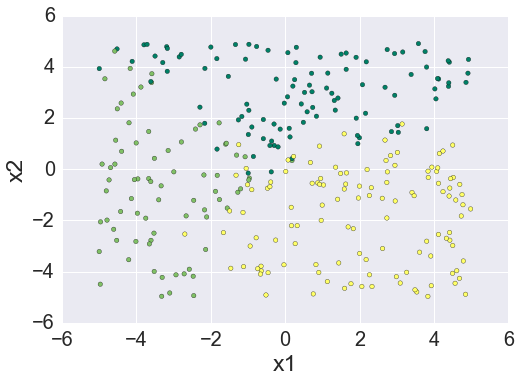

In [55]:
# data generation
SIZE = 300
xn = (npr.rand(SIZE,DIMX)-0.5)*10.

model = moon.Multiclass(DIMX,DIMY)
wn = np.asarray([[1,-1,2],
                 [1,-1,-2]])            # DIMX, DIMY
bn = np.asarray([1, 1, 3])              # DIMY
                      
model.setTrueParamValues( w=wn,b=bn )
data = model.genData(fromx=xn, verbose=True)
fig = plotZ.category2d(data['x'],data['label'],dotarea=20, cmap='summer')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('x1',fontsize=23); plt.ylabel('x2',fontsize=23)
if SAVE_FLAG:
    plt.savefig(ROOT+'/data.png')

In [35]:
# posterior
LOW, HIGH = -7,+7
GAP = (HIGH-LOW)/400.
gps, g1, g2 = mathZ.gridPoints((LOW,HIGH,GAP), (LOW,HIGH,GAP))

xname, yname = 'w11', 'w12'
idx1 = [0,0]
idx2 = [0,1]
L = gps.shape[0]
wns = np.repeat(wn.reshape((1,DIMX,DIMY)),L,axis=0)
bns = np.repeat(bn.reshape((1,DIMY)), L, axis=0)
wns[:, idx1[0], idx1[1] ] = gps[:,0]
wns[:, idx2[0], idx2[1] ] = gps[:,1]

logs_, logall_ = model.nlogPy_xw(data['x'],data['y'],wns,bns)
print logs_.shape, logall_.shape

(160000,) (160000, 300)


In [36]:
# parameter setup
PRIOR_WEIGHT = 0.1

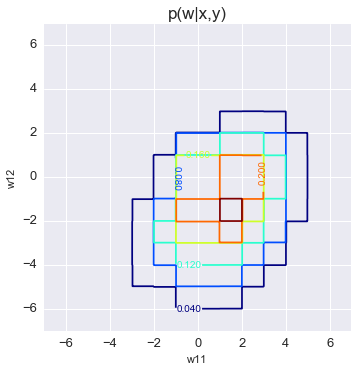

In [37]:
logs = logs_ + model.nlogPw(wns)*PRIOR_WEIGHT
pws = logs.reshape(g1.shape[1],g2.shape[0]) 
pws = np.exp(pws)
fig = plt.figure()
CS = plt.contour(g1,g2,pws,cmap='jet')
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.xlabel(xname); plt.ylabel(yname)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('p(w|x,y)', fontsize=17)
plt.show()

In [155]:
##
## VARIATIONAL INFERENCE
##            parameter setup
##
SAMPLINGNUM = 20
NUM_LAYERS = 4
NF_TYPE,STD = 'normal',1.0
DIMNF = LENW+DIMY
NUMITER = 10000
print 'dimensions :\n\t w : %d*%d, b : %d, NF : %d' % (DIMX, DIMY, DIMY,DIMNF)

dimensions :
	 w : 2*3, b : 3, NF : 9


In [156]:
# construction variational model
iaf = nf.NormFlowModel( dim=DIMNF, numlayers=NUM_LAYERS,noisestd=STD, z0type=NF_TYPE)  
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)  # z = L * ( dimx * dimy + dimy )

# matching latent variables to parameters
wt = z[:, :LENW].reshape( (SAMPLINGNUM,DIMX,DIMY) )
bt = z[:, LENW:]

print 'w : %s\nb : %s\nlogqz : %s' % ( wt.shape.eval(), bt.shape.eval(), logqz.shape.eval() )

w : [20  2  3]
b : [20  3]
logqz : [20]


In [157]:
# setting cost variable
x = utils.theanoGeneral.sharedf(data['x'])
y = utils.theanoGeneral.sharedf(data['y'])

logpy_xw, temp = model.logPy_xw(x,y,wt,bt)
logpw = model.logPw(wt,bt)

In [158]:
# ELBO
cost = T.mean( logqz - ( logpy_xw + logpw*PRIOR_WEIGHT ) )  # negative-ELBO

params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [159]:
# optimisation setup
iaf.reInit()
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpy_xw), T.mean(logqz) ]
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [160]:
# training

keys = ['cost','pxyw','qz']
record = {}

# mb.setStd(0.7)
for k in keys:
    record[k] = []
for i in range(NUMITER):
    out = estep()
    for i,q in enumerate(out):
        record[keys[i]].append( q )        
for k in keys:
    record[k] = np.asarray( record[k] )

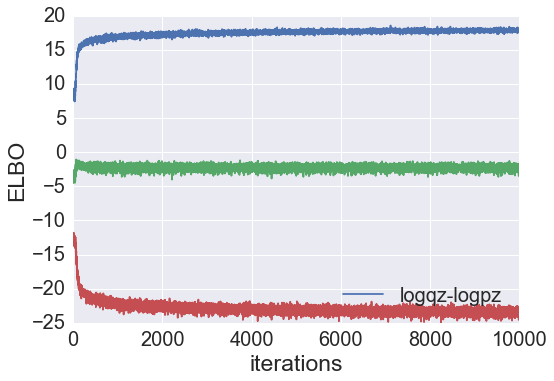

In [161]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)
plt.plot( xs, -record['cost'], '-', label='logqz-logpz')
plt.xlabel('iterations',fontsize=23)
plt.ylabel('ELBO',fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.legend(fontsize=20,loc=4)
plt.tick_params(axis='both', which='major', labelsize=20)
if SAVE_FLAG:
    plt.savefig(ROOT+'/elbo_L%d.png'%NUM_LAYERS)
plt.plot( xs, record['pxyw'], '-', label='log-pxz')
plt.plot( xs, record['qz'], '-', label='log-qz')
plt.show()

In [162]:
# testing accuracy
ess = iaf.getNoiseVar(5000)
zss, logqzss = iaf.reparam(ess)
fez2 = theano.function(inputs=[],outputs=[zss])
model_t = moon.Multiclass(DIMX,DIMY)

In [163]:
zsample = fez2()[0]
# matching latent variables to parameters
wsample = zsample[:, :LENW].reshape( (-1,DIMX,DIMY) )
bsample = zsample[:, LENW:]
lout = model_t.nPredict(data['x'],wsample,bsample)
acc, acc_ = model_t.nAcc(data['label'],lout)
print np.mean( acc )
print np.var(acc)

0.677354
0.0190713075729


In [164]:
###
### SAVING
###
SAVEPATH = ROOT+'/record_L%d.npz'%NUM_LAYERS
np.savez(SAVEPATH, x = data['x'], y=data['y'], 
         prior_weight=PRIOR_WEIGHT, numiter=NUMITER,
        numlayers=NUM_LAYERS, nftype=NF_TYPE, std=STD,
        cost=record['cost'], acc=np.mean(acc), accvar = np.var(acc) )

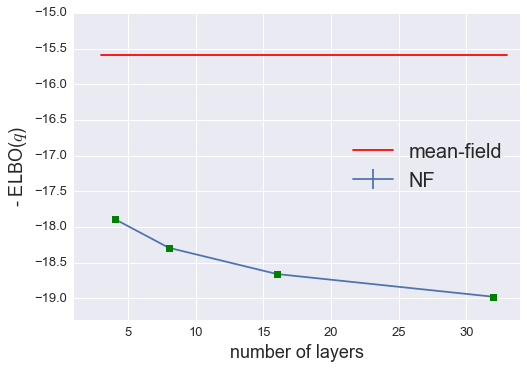

In [189]:
## INDEPENDENT
##     Statistica of the variational bound
##

NUM_LS = [4,8,16,32]

record_mf = np.load( ROOT + '/mf/record.npz' )
cost_mf = np.mean( record_mf['cost'][-500:] )

rs = list()
costs = list()
for i, L in enumerate(NUM_LS):
    rs.append(  np.load(ROOT+'/record_L%d.npz'%L) )
    costs.append( -rs[-1]['cost'][-500:] )
costs = np.asarray( costs )
bars = [ np.var(costs[i]) for i in range(len(NUM_LS)) ]
costs = np.mean(costs,axis=1)

plt.errorbar(NUM_LS,-costs,yerr=bars,label='NF')
plt.plot( NUM_LS, -costs, 'sg')
plt.plot( [3,33],[cost_mf,cost_mf],'-r',label='mean-field')
    
plt.xlabel('number of layers',fontsize=18)
plt.ylabel('- ELBO($q$)',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlim([1,NUM_LS[-1]+2])
plt.ylim([-19.3,-15])
plt.legend(fontsize=20,loc='center right')
plt.savefig(ROOT+'/ELBOvsL.png')

In [ ]:
wn = np.asarray([[1,-1,2],
                 [1,-1,-2]]) 
bn = np.asarray([1, 1, 3])  

ww = np.asarray( [wn,wn] )
bb = np.asarray( [bn,bn] )

lout = model_t.nPredict(data['x'],ww,bb)
acc, acc_ = model_t.nAcc(data['label'],lout)
print np.mean( acc )
print np.var(acc)

